<h1>Training Neural Networks</h1>

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

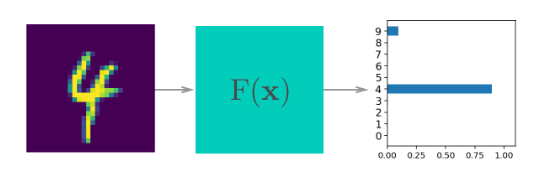



## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [50]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [51]:
#Fazendo download do dataset do MNIST
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Um DataLoader é uma classe em PyTorch que fornece uma interface conveniente para iterar sobre conjuntos de dados durante o treinamento ou teste de modelos de aprendizado de máquina, especialmente em tarefas de aprendizado supervisionado, como classificação ou regressão.

Especificamente, um DataLoader é usado para carregar os dados de um conjunto de dados e agrupá-los em lotes (batches). Isso é útil porque durante o treinamento de modelos de aprendizado de máquina, os dados geralmente são processados em lotes, não de forma individual.

In [52]:
# Build a feed-forward network
# Construção da Rede Neural:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Isso cria uma rede neural com três camadas lineares (fully connected) intercaladas com funções de ativação ReLU.

# Definição da Função de Perda:
criterion = nn.CrossEntropyLoss()
# Aqui, é definida a função de perda CrossEntropyLoss, que é comumente usada em
# problemas de classificação multiclasse. Esta função de perda combina uma função de 
# softmax com a função de entropia cruzada (cross-entropy), que é uma medida de
# quão bem o modelo de classificação está realizando. (logs)

# Obtenção dos Dados de Treinamento:
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Aqui, iter(trainloader) cria um iterador para o trainloader, 
# que é o DataLoader que contém os dados de treinamento. 
# next(dataiter) obtém o próximo lote de dados de treinamento, 
# que consiste em imagens (images) e seus rótulos correspondentes (labels).

# Processamento dos Dados:
images = images.view(images.shape[0], -1)
# Como as imagens estão no formato (batch_size, 1, 28, 28), esta linha redimensiona
# as imagens para que elas tenham a forma (batch_size, 784), para que possam ser 
# usadas como entrada para a rede neural.

# Passagem para Frente (Forward Pass):
logits = model(images)
# Isso realiza uma passagem para frente pela rede neural, onde as imagens
# são passadas pela rede e as previsões (logits) são calculadas.

# Calculate the loss with the logits and the labels
# Cálculo da Perda:
loss = criterion(logits, labels)
# Aqui, a função de perda é calculada comparando as previsões (logits) com os 
# rótulos verdadeiros (labels). A função CrossEntropyLoss já inclui a aplicação da 
# função softmax e o cálculo da entropia cruzada, portanto, não é necessário aplicar 
# a função softmax explicitamente na saída do modelo.

print(loss)
# Imprime o valor da perda calculada para o lote de dados de treinamento atual.

tensor(2.3507, grad_fn=<NllLossBackward0>)


`Exercise:` Construa um modelo que retorne o log-softmax como saída e calcule a perda utilizando a perda de log-verossimilhança negativa (negative log likelihood loss). Note que para nn.LogSoftmax e F.log_softmax, você precisará definir corretamente o argumento de palavra-chave dim. dim=0 calcula o softmax pelas linhas, de modo que cada coluna some para 1, enquanto dim=1 calcula pelas colunas, de modo que cada linha some para 1. Pense sobre o que você deseja que a saída seja e escolha dim apropriadamente.

In [53]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))  # Modificando a última camada para retornar log-softmax

# Para cada linha (ou amostra) de logits, a log-softmax será calculada, garantindo que  a operação de 
# log-softmax normaliza os logits para que, após a exponenciação e a normalização, eles representem as
# probabilidades logarítmicas para cada classe. Essas probabilidades estarão na faixa de 0 a 1

# Portanto, nn.LogSoftmax(dim=1) é uma camada que aplica a operação de log-softmax aos logits de
# saída da rede neural ao longo da dimensão especificada. Essa camada é comumente usada como a última 
# camada de uma rede neural em problemas de classificação, quando a saída da rede precisa ser convertida 
# em probabilidades normalizadas para cada classe.

# TODO: Define the loss
criterion = nn.NLLLoss()
# With a log-softmax output, you want to use the negative log likelihood loss, nn.NLLLoss
# Usando a perda de log-verossimilhança negativa

### Run this to check your work
# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images) #log probabilidades
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3164, grad_fn=<NllLossBackward0>)


Os "logits" são os valores de saída brutos gerados pela última camada de uma rede neural antes da aplicação de uma função de ativação. Em problemas de classificação, os logits representam as pontuações associadas a cada classe possível.

Os logits não representam diretamente as probabilidades de cada classe (por exemplo, de 0 a 9), mas sim uma medida da "confiança" da rede neural de que a entrada pertence a cada classe. Os valores de logits não são restritos ao intervalo de 0 a 1, como as probabilidades, e podem assumir qualquer valor real.

Por exemplo, suponha que tenhamos um problema de classificação com 3 classes (A, B e C) e a saída da última camada da rede neural seja uma lista de logits [2.3, -1.1, 0.5]. Isso significa que a rede neural atribui uma "pontuação" de 2.3 para a classe A, -1.1 para a classe B e 0.5 para a classe C.

Após a obtenção dos logits, aplicamos uma função de ativação para transformá-los em probabilidades. Uma função comum para isso é a função softmax, que normaliza os logits de forma que as probabilidades somem para 1. Portanto, os logits não representam diretamente as probabilidades de cada classe, mas sim as pontuações associadas a cada classe antes da normalização.

## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

## notas
requires_grad=True diz para o PyTorch rastrear as operações nesse tensor x, assim, caso você queira o gradiente ele irá calcular para você.

Basicamente, é assim que funciona:

você cria seu tensor, seta requires_grad=True e executa operações nele.
quando você terminar as operações, digite z.backward()

O PyTorch sabe que os gradientes devem ser calculados em relação aos tensores que têm requires_grad=True. Quando chamamos z.backward(), estamos essencialmente dizendo ao PyTorch para calcular os gradientes de z em relação a todos os tensores que têm requires_grad=True.

No exemplo fornecido, z é uma função da variável x (ou seja, z depende de x). Como x tem requires_grad=True, o PyTorch rastreia todas as operações realizadas em x para calcular z. Quando chamamos z.backward(), o PyTorch sabe que deve calcular os gradientes de z em relação a x, porque x foi usado para calcular z.

In [54]:
x = torch.randn(2,2, requires_grad=True) 
# Cria um tensor x de forma (2,2) com valores aleatórios e define requires_grad=True para rastrear as operações nele.
print(x)

tensor([[ 1.3267, -1.4178],
        [-1.1249,  1.0917]], requires_grad=True)


In [55]:
y = x**2
#  Calcula o quadrado de cada elemento em x.
print(y)

tensor([[1.7602, 2.0102],
        [1.2654, 1.1918]], grad_fn=<PowBackward0>)


In [56]:

## grad_fn shows the function that generated this variable
print(y.grad_fn)
# Imprime a função que gerou y, que neste caso é a função de potência.

In [57]:
z = y.mean()
#  Calcula a média de todos os elementos em y.
print(z)

tensor(1.5569, grad_fn=<MeanBackward0>)


In [58]:

print(x.grad)
# Imprime os gradientes de x até este momento. Como nenhum cálculo de gradiente foi feito ainda, isso resultará em None.

None


In [59]:
z.backward() # Calcula os gradientes de z em relação a x.
print(x.grad) 
#  Imprime os gradientes de x após o cálculo. Isso agora terá valores, representando os gradientes de z em relação a x.
print(x/2)
#  Imprime x dividido por 2. Isso serve para verificarmos manualmente se os gradientes estão corretos. 
# Os gradientes calculados por backward() devem ser metade dos valores de x, 
# já que a média de y é calculada a partir de x ao quadrado.

tensor([[ 0.6634, -0.7089],
        [-0.5625,  0.5459]])
tensor([[ 0.6634, -0.7089],
        [-0.5625,  0.5459]], grad_fn=<DivBackward0>)


## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [60]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [61]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0043,  0.0043,  0.0043,  ...,  0.0043,  0.0043,  0.0043],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        ...,
        [ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [-0.0029, -0.0029, -0.0029,  ..., -0.0029, -0.0029, -0.0029],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004]])


Podemos usar esses gradientes para treinar nossa rede neural!

## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [62]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [66]:
print('Initial weights - ', model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# zera os gradientes antes de iniciar um novo passo de treinamento.
# Isso é necessário porque os gradientes são acumulados a cada chamada de backward(), 
# e se não forem zerados, os gradientes acumulados de lotes anteriores afetarão os
# cálculos de gradiente para lotes futuros.
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images) # MODEL DEFINIDO ANTES!
loss = criterion(output, labels)
# CRITERION (FUNÇÃO DE PERDA) DEFINIDO ANTES!
# Calcula a perda (loss) usando as previsões do modelo (output) e os rótulos verdadeiros (labels). 

loss.backward()
# Executa uma passagem para trás através da rede neural. 
# Isso calcula os gradientes de todas as variáveis que têm requires_grad=True com relação à perda (loss). 
# Esses gradientes são usados para atualizar os pesos da rede neural durante a etapa de otimização.

print('Gradient -', model[0].weight.grad)
# imprime os gradientes dos pesos da primeira camada linear da rede neural após a chamada 
# de backward(). Isso permite visualizar como os gradientes dos pesos estão mudando ao longo do
# treinamento. Isso é útil para entender como os pesos estão sendo ajustados durante o treinamento da rede neural.

Initial weights -  Parameter containing:
tensor([[ 0.0328, -0.0165, -0.0145,  ...,  0.0069, -0.0026,  0.0036],
        [-0.0139, -0.0071,  0.0115,  ..., -0.0034, -0.0156, -0.0291],
        [-0.0089,  0.0224, -0.0111,  ...,  0.0061,  0.0126, -0.0344],
        ...,
        [-0.0253, -0.0145,  0.0276,  ..., -0.0260, -0.0328, -0.0111],
        [ 0.0255, -0.0068, -0.0173,  ..., -0.0134, -0.0036,  0.0016],
        [ 0.0211, -0.0131, -0.0321,  ...,  0.0304, -0.0282, -0.0217]],
       requires_grad=True)
Gradient - tensor([[ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0047, -0.0047, -0.0047,  ..., -0.0047, -0.0047, -0.0047],
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026],
        ...,
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        [ 0.0035,  0.0035,  0.0035,  ...,  0.0035,  0.0035,  0.0035]])


In [67]:
# Take an update step and view the new weights
optimizer.step()
# atualiza os pesos da rede neural usando o otimizador. 
# O otimizador ajusta os pesos com base nos gradientes calculados durante a passagem para trás.

print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0328, -0.0165, -0.0145,  ...,  0.0069, -0.0026,  0.0035],
        [-0.0139, -0.0070,  0.0115,  ..., -0.0033, -0.0156, -0.0291],
        [-0.0089,  0.0224, -0.0111,  ...,  0.0061,  0.0126, -0.0344],
        ...,
        [-0.0253, -0.0145,  0.0276,  ..., -0.0260, -0.0328, -0.0111],
        [ 0.0255, -0.0068, -0.0173,  ..., -0.0134, -0.0036,  0.0016],
        [ 0.0210, -0.0132, -0.0321,  ...,  0.0304, -0.0282, -0.0217]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll be doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Exercise:** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [70]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9395466408749888
Training loss: 0.9106576813500065
Training loss: 0.5522416554280182
Training loss: 0.4411144864235097
Training loss: 0.38859818743935015


With the network trained, we can check out it's predictions.

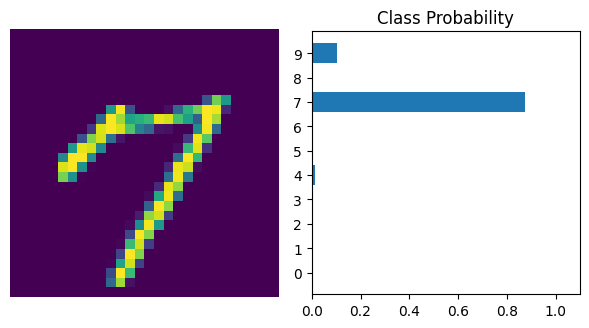

In [71]:
%matplotlib inline
import helper

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)